# Topics in Econ HW2

In [340]:
import requests                 
import bs4 
import re
import time
import pandas as pd
from datetime import datetime
from nltk.tokenize import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
import string
from torch.nn.functional import softmax
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, pipeline
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## 1. Measuring Hawkish/Dovish Tone of FOMC Statements (100 points)

### 1.1 Scrape FOMC Statements

In [44]:
def gen_soup_bs4(url):
    '''takes a url and returns a soup object'''
    
    headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 5.1.1; SM-G928X Build/LMY47X) ' + \
                              'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.83 Mobile Safari/537.36',
              "Accept-Encoding":"gzip, deflate", 
              "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
              "DNT":"1","Connection":"close", 
              "Upgrade-Insecure-Requests":"1"}

    response = requests.get(url = url, headers = headers)
    assert response.status_code == 200 #need to be 200 (ideally)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    time.sleep(1)
    
    return soup

def generate_absolute_url(relative_url):
    '''get absolute URL from relative URL'''
    
    domain = 'https://www.federalreserve.gov'
    return domain + relative_url

In [45]:
seed_url = 'https://www.federalreserve.gov/monetarypolicy/fomchistorical{}.htm'
pre2016 = [seed_url.format(n) for n in range(2000, 2017)]

pre2016_statements_url = []

for url in pre2016:
    soup = gen_soup_bs4(url)
    for i in soup.find_all('a', {'href': re.compile(r'\/\w+\/press\w*\/')}):  
        if i.text.lower() == 'statement':
            statement_url = generate_absolute_url(i['href'])
            pre2016_statements_url.append(statement_url)

seed_url_2017 = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
soup_post2017 = gen_soup_bs4(seed_url_2017)

post2017_statements_url = []
for i in soup_post2017.find_all('a', {'href': re.compile(r'\/newsevents\/pressreleases\/')}):
    if i.text.lower() == 'html': #just get the statements
        statement_url = generate_absolute_url(i['href'])
        post2017_statements_url.append(statement_url)

all_urls = pre2016_statements_url + post2017_statements_url

In [46]:
#scrape the text of statements
data = {
    'date': [],
    'full_text': []
}

for url in all_urls:
    
    statement_soup = gen_soup_bs4(url)
    date = re.findall(r'\d{5,}', url)[0] #get date of the statement 
    year = int(date[:4]) #year of statement
    
    #federal reserve changed their website after 2005. Need to cater differently
    if year < 2006:
        try: 
            txt = statement_soup.find_all('tr')[1].text 
        except:
            txt = statement_soup.find_all('tr')[0].text
    else:
        txt = statement_soup.find('div', attrs={'class': 'col-xs-12 col-sm-8 col-md-8'}).text
    
    #remove unnecessary text
    for pattern in ['(\\n|\\t|\\r)', 'Voting .* policy .* were.*',
                   '(For immediate release|For release at .* E*T)', 
                   'Frequently Asked Questions.*',
                   '[\w\s]+other central banks is available at the following websites:.*',
                   'Release Date:.*?(?=T)']:
        txt = re.sub(pattern, '', txt)
    
    data['date'].append(date)
    data['full_text'].append(txt)
    
statements_df = pd.DataFrame(data)
statements_df['date'] = pd.to_datetime(statements_df['date'])
statements_df.sort_values('date', inplace=True)

In [47]:
statements_df

,date,full_text
0,2000-02-02,The Federal Open Market Committee voted today ...
1,2000-03-21,The Federal Open Market Committee voted today ...
2,2000-05-16,The Federal Open Market Committee voted today ...
3,2000-06-28,The Federal Open Market Committee at its meeti...
4,2000-08-22,The Federal Open Market Committee at its meeti...
...,...,...
146,2023-03-22,Recent indicators point to modest growth in sp...
147,2023-05-03,Economic activity expanded at a modest pace in...
148,2023-06-14,Recent indicators suggest that economic activi...
149,2023-07-26,Recent indicators suggest that economic activi...


In [10]:
# statements_df = pd.read_excel('fomc_statements.xlsx')

(a) How many statements do you obtain?

In [13]:
statements_df['count'] = statements_df['full_text'].apply(lambda x: len(x.split()))
len(statements_df)

194

(b) Provide summary statistics (mean, standard deviation, minimum, first quartile, median, third quartile, maximum) for the number of words in each statement.


In [37]:
statements_df['count'].describe()

count    194.000000
mean     323.742268
std      169.926853
min       77.000000
25%      175.000000
50%      286.000000
75%      430.500000
max      798.000000
Name: count, dtype: float64

### 1.2 Measure the tone of each speech

In [48]:
keywords = pd.read_excel('Tadle2022_keywords.xlsx')
dff = pd.read_csv('DFF.csv')
dff['DATE']=pd.to_datetime(dff['DATE'])

In [49]:
keywords

,hawkish,dovish,positive,negative,negation
0,business,accomodation,abating,adverse,fail
1,economy,downturn,augmented,contracting,less
2,equity,unemployment,booming,damping,never
3,housing,devastation,elevating,declining,no
4,inflationary,recession,extended,depressed,not
...,...,...,...,...,...
82,NaN,NaN,NaN,slowing,NaN
83,NaN,NaN,NaN,soft,NaN
84,NaN,NaN,NaN,strains,NaN
85,NaN,NaN,NaN,underutilization,NaN


In [50]:
dff

,DATE,DFF
0,2000-01-01,3.99
1,2000-01-02,3.99
2,2000-01-03,5.43
3,2000-01-04,5.38
4,2000-01-05,5.41
...,...,...
8692,2023-10-19,5.33
8693,2023-10-20,5.33
8694,2023-10-21,5.33
8695,2023-10-22,5.33


In [51]:
hawkish_keywords = set(keywords['hawkish'].dropna())
dovish_keywords = set(keywords['dovish'].dropna())
positive_keywords = set(keywords['positive'].dropna())
negative_keywords = set(keywords['negative'].dropna())
negation_terms = set(keywords['negation'].dropna()) 

In [52]:
def process_text(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Define punctuation to be removed
    punc = set(string.punctuation)

    processed_sentences = []
    for sent in sentences:
        # Remove punctuation and convert to lowercase
        cleaned_text = ''.join(char for char in sent if char not in punc).lower()
        # Remove all sentences that do not contain any keywords (defined as those from the hawkish or dovish lists)
        if any(word in cleaned_text.split() for word in hawkish_keywords or dovish_keywords):
            processed_sentences.append(cleaned_text)
    processed_text = '.'.join(processed_sentences)
    return processed_text

In [53]:
def analyze_sentence(sentence):
    lines = sentence.split('.')
    sent_score = 0
    net_score = 0

    for line in lines:
        words = line.split(' ')
        # print(line)
        if any(word in hawkish_keywords for word in words):
            tone = 'hawkish'
        else:
            tone = 'dovish'

        for i, word in enumerate(words):
            # print(word)
            if word in positive_keywords:
                if any(sentence[j] in negation_terms for j in range(max(0,i-3), i)):  # Check negation within previous 3 words
                    net_score -= 1
                else:
                    net_score += 1
            elif word in negative_keywords:
                if any(sentence[j] in negation_terms for j in range(max(0,i-3), i)):  # immediately follows a negation term
                    net_score += 1
                else:
                    net_score -= 1

        if tone == 'hawkish' and net_score > 0:
            sent_score +=1
        elif tone == 'hawkish' and net_score < 0:
            sent_score -=1
        elif tone == 'dovish' and net_score > 0:
            sent_score -=1
        elif tone == 'dovish' and net_score < 0:
            sent_score +=1      

    return sent_score

In [54]:
statements_df['processed_text'] = statements_df['full_text'].apply(process_text)
statements_df['sent_score'] = statements_df['processed_text'].apply(analyze_sentence)
statements_df

,date,full_text,processed_text,sent_score
0,2000-02-02,The Federal Open Market Committee voted today ...,the federal open market committee voted today ...,4
1,2000-03-21,The Federal Open Market Committee voted today ...,the federal open market committee voted today ...,4
2,2000-05-16,The Federal Open Market Committee voted today ...,the federal open market committee voted today ...,3
3,2000-06-28,The Federal Open Market Committee at its meeti...,the federal open market committee at its meeti...,1
4,2000-08-22,The Federal Open Market Committee at its meeti...,the federal open market committee at its meeti...,0
...,...,...,...,...
146,2023-03-22,Recent indicators point to modest growth in sp...,recent indicators point to modest growth in sp...,6
147,2023-05-03,Economic activity expanded at a modest pace in...,economic activity expanded at a modest pace in...,5
148,2023-06-14,Recent indicators suggest that economic activi...,recent indicators suggest that economic activi...,10
149,2023-07-26,Recent indicators suggest that economic activi...,recent indicators suggest that economic activi...,9


In [55]:
df = dff.merge(statements_df, left_on='DATE', right_on='date', how='inner')
df = df[['date','DFF','sent_score']]
df

,date,DFF,sent_score
0,2000-02-02,5.64,4
1,2000-03-21,5.81,4
2,2000-05-16,6.13,3
3,2000-06-28,6.50,1
4,2000-08-22,6.42,0
...,...,...,...
189,2023-03-22,4.58,6
190,2023-05-03,4.83,5
191,2023-06-14,5.08,10
192,2023-07-26,5.08,9


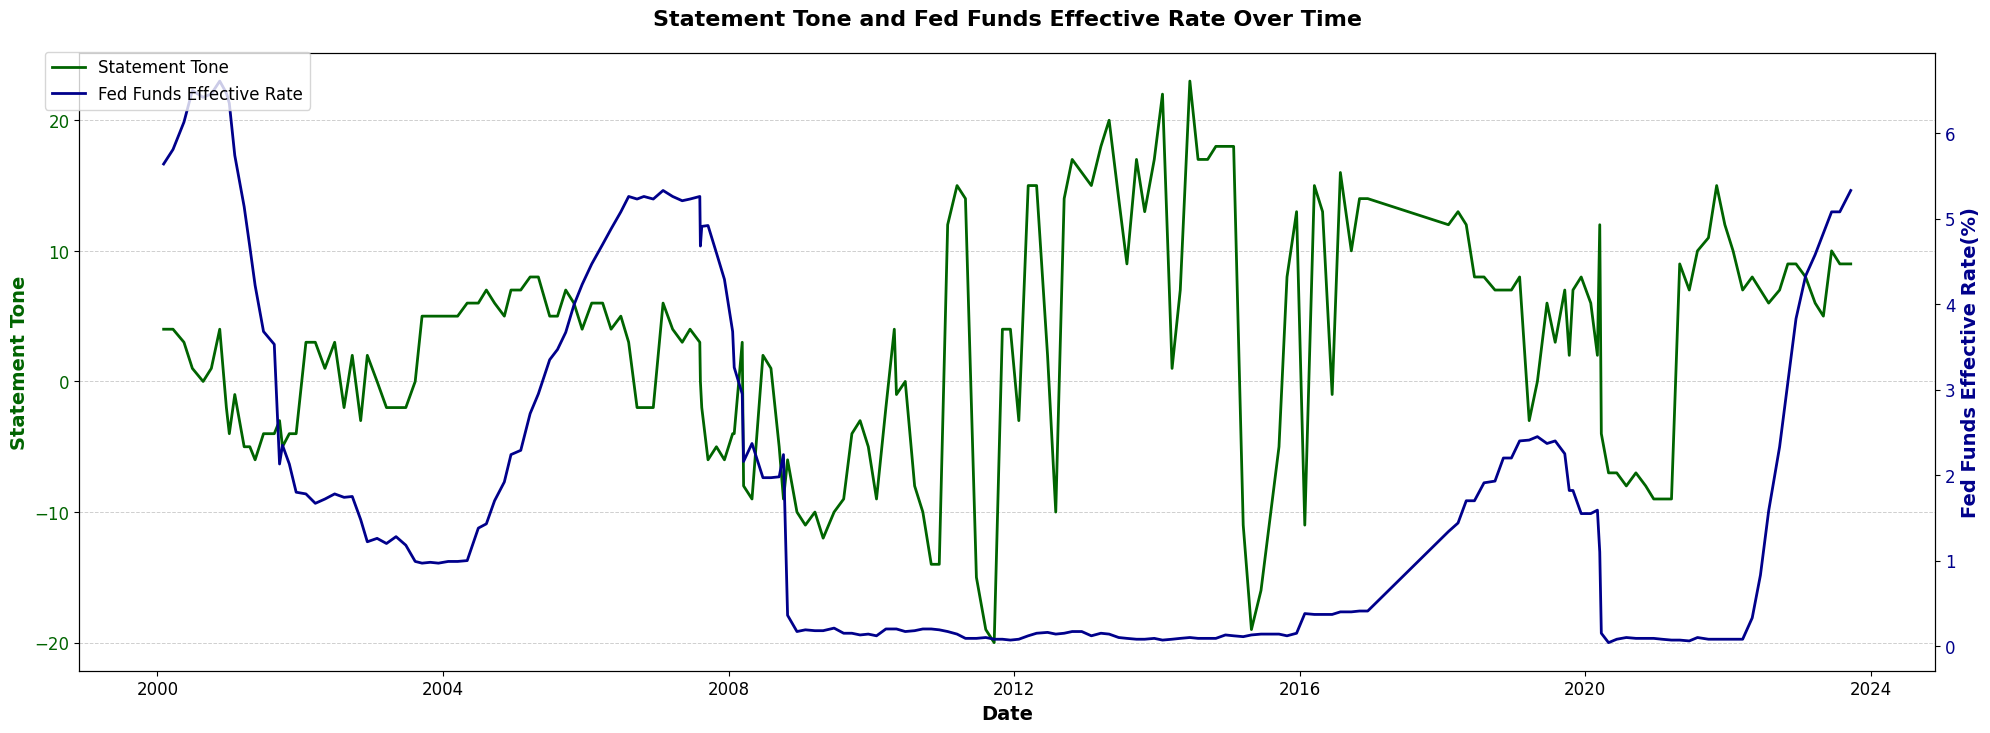

In [84]:
fig, ax1 = plt.subplots(figsize=(20, 7))

color = 'darkgreen'
ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
ax1.set_ylabel('Statement Tone', color=color, fontsize=14, fontweight='bold')
line1, = ax1.plot(df['date'], df['sent_score'], color=color, label='Statement Tone', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

ax2 = ax1.twinx()
color = 'darkblue'
ax2.set_ylabel('Fed Funds Effective Rate(%)', color=color, fontsize=14, fontweight='bold')
line2, = ax2.plot(df['date'], df['DFF'], color=color, label='Fed Funds Effective Rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='y', labelsize=12)

fig.tight_layout()
fig.legend(handles=[line1, line2], loc='upper left', fontsize=12, borderaxespad=0., bbox_to_anchor=(0.025, 0.98))

plt.title("Statement Tone and Fed Funds Effective Rate Over Time", fontsize=16, fontweight='bold', pad=20)
plt.show()


### 1.3 Comment on the Tadle (2022) methodology. What do you like about it? What are its shortcomings?

- What I like: It's quite easy and straightforward, the author has a good understanding of what terms could lead to hawkish or dovish,and by using positive, negative on the top of that, this method is doing a good job capturing nuanced statements and there is flexibility to add or remove terms from the keyword list.
- Shortcomings: There is a bug dependency on the keyword list, and it can be manipulated to tap into the result they wanted.

### 1.4 Describe and implement a different way to measure hawkish/dovish tone of FOMC statements.3 How does your alternative measure address some of the shortcomings in the Tadle (2022) method? What is the correlation between the Tadle (2022) measure and your measure?

Instead of using the keywords list, I used BERT model to do the sentiment analysis on the FOMC statements, this reduce the dependence on the keyword list and avoid any subjective judegement when doing the sentiment analysis. Another good thing is that it can be easily scaled yet still maintain the similar level of performance.

In [15]:
# Initialize the sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

In [34]:
def sentiment_score(statement):
    try:
        result = sentiment_pipeline(statement)[0]
        label = result["label"]
        score = result["score"]
        
        if label == "POSITIVE":
            return score
        elif label == "NEGATIVE":
            return -score
        
    except Exception as e:
        score = 0

In [60]:
def analyze_sentence_2(sentence):
    lines = sentence.split('.')
    sent_score = 0

    for line in lines:
        score = sentiment_score(line)
        sent_score += score

    return sent_score

In [61]:
statements_df['sent_score_2'] = statements_df['processed_text'].apply(analyze_sentence_2)

In [62]:
statements_df['sent_score_2'].describe()

count    194.000000
mean      -1.239476
std        2.332129
min       -7.650847
25%       -2.897442
50%       -1.506407
75%        0.288382
max        6.666866
Name: sent_score_2, dtype: float64

The correlation between Tadle measure and my measure is quite low - 0.18, however, if look at the correlation between DFF, my measure actually has a relatively higher correlation.

In [82]:
statements_df.corr()

,sent_score,sent_score_2
sent_score,1.000000,0.189944
sent_score_2,0.189944,1.000000


In [185]:
df = dff.merge(statements_df, left_on='DATE', right_on='date', how='inner')
df = df[['date','DFF','sent_score','sent_score_2']]
df

,date,DFF,sent_score,sent_score_2
0,2000-02-02,5.64,4,-3.772988
1,2000-03-21,5.81,4,-3.815530
2,2000-05-16,6.13,3,-2.826711
3,2000-06-28,6.50,1,0.422014
4,2000-08-22,6.42,0,-1.925802
...,...,...,...,...
189,2023-03-22,4.58,6,3.615172
190,2023-05-03,4.83,5,2.620852
191,2023-06-14,5.08,10,3.767323
192,2023-07-26,5.08,9,2.715870


In [83]:
df.corr()

,DFF,sent_score,sent_score_2
DFF,1.000000,-0.053812,0.236181
sent_score,-0.053812,1.000000,0.189944
sent_score_2,0.236181,0.189944,1.000000


### 1.5 Redo the plot from problem 2, adding your tone measure. Your plot should include the Tadle (2022) measure, your measure and the Fed Funds Effective Rate.

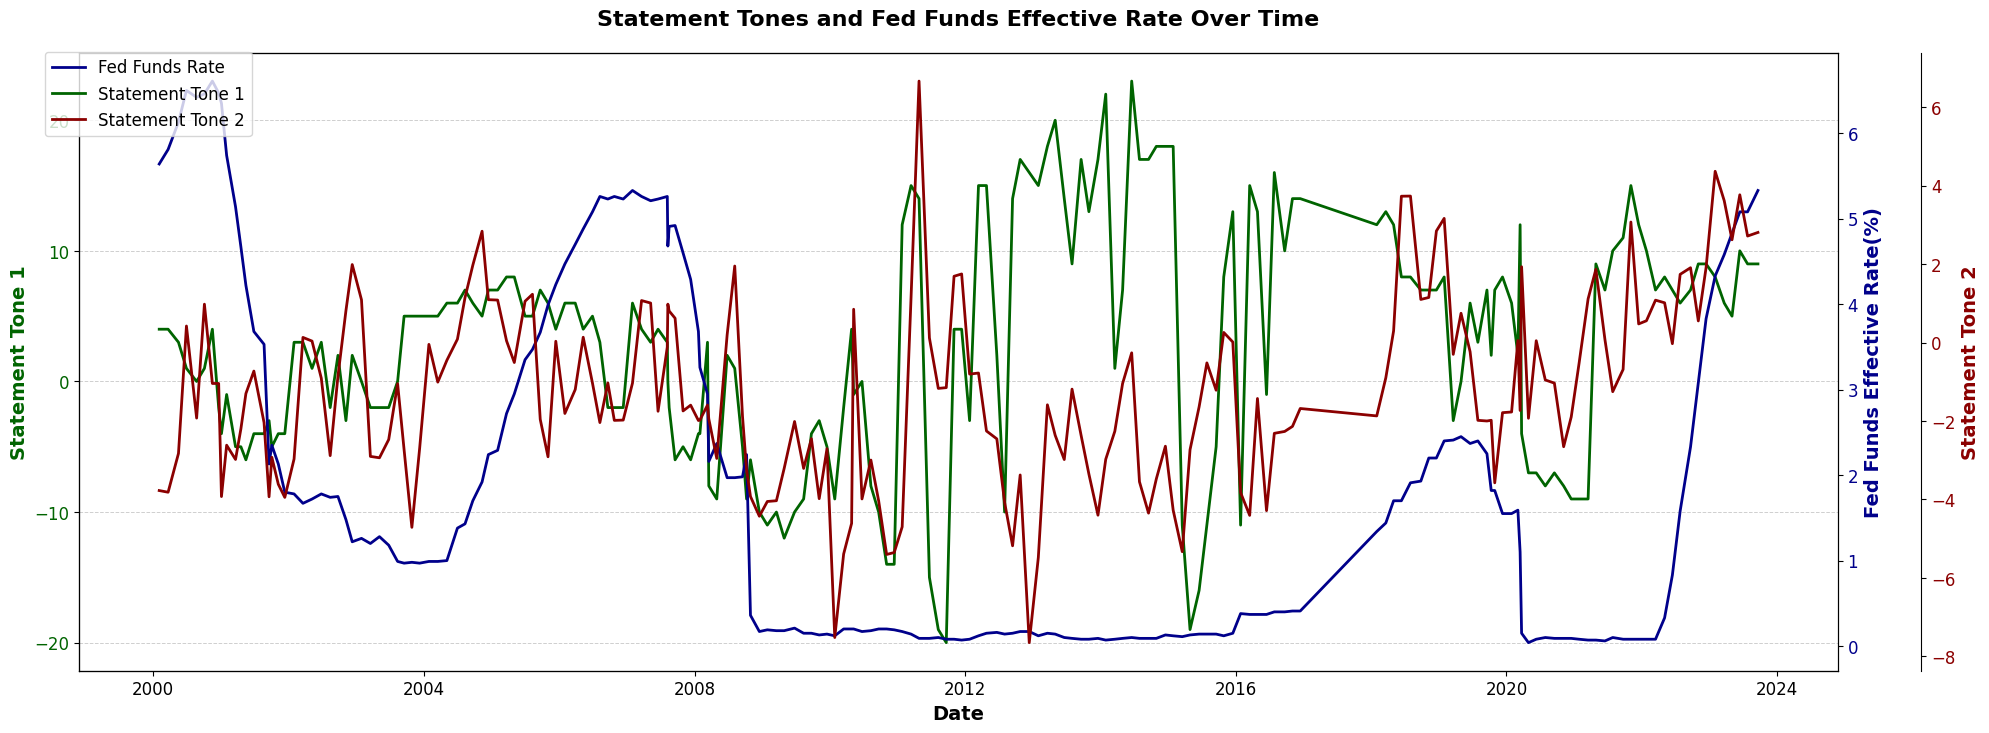

In [86]:
fig, ax1 = plt.subplots(figsize=(20, 7))

color = 'darkgreen'
ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
ax1.set_ylabel('Statement Tone 1', color=color, fontsize=14, fontweight='bold')
line1, = ax1.plot(df['date'], df['sent_score'], color=color, label='Statement Tone 1', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

ax2 = ax1.twinx()
color = 'darkblue'
ax2.set_ylabel('Fed Funds Effective Rate(%)', color=color, fontsize=14, fontweight='bold')
line2, = ax2.plot(df['date'], df['DFF'], color=color, label='Fed Funds Rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='y', labelsize=12)

ax3 = ax1.twinx()  
ax3.spines['right'].set_position(('outward', 60))  
color = 'darkred'
ax3.set_ylabel('Statement Tone 2', color=color, fontsize=14, fontweight='bold')
line3, = ax3.plot(df['date'], df['sent_score_2'], color=color, label='Statement Tone 2', linewidth=2)
ax3.tick_params(axis='y', labelcolor=color)
ax3.tick_params(axis='y', labelsize=12)

fig.tight_layout()
fig.legend(handles=[line2, line1, line3], loc='upper left', fontsize=12, borderaxespad=0., bbox_to_anchor=(0.025, 0.98))

plt.title("Statement Tones and Fed Funds Effective Rate Over Time", fontsize=16, fontweight='bold', pad=20)

plt.show()


### 1.6 Complete this problem twice: once with the Tadle (2022) measure of hawkishness and once with your measure. The steps will guide you through using the Fama and MacBeth (1973) procedure to estimate the monetary policy risk premium in industry returns data.4 In particular:

(a) Estimate an AR(1) model from the hawkishness data. Compute the residual. We will call this the “text-based monetary policy shock.”

In [236]:
model = AutoReg(df['sent_score'], lags=1).fit()

print(model.summary())


                            AutoReg Model Results                             
Dep. Variable:             sent_score   No. Observations:                  194
Model:                     AutoReg(1)   Log Likelihood                -632.723
Method:               Conditional MLE   S.D. of innovations              6.420
Date:                Wed, 25 Oct 2023   AIC                           1271.446
Time:                        05:21:24   BIC                           1281.235
Sample:                             1   HQIC                          1275.410
                                  194                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8872      0.484      1.835      0.067      -0.061       1.835
sent_score.L1     0.6803      0.053     12.865      0.000       0.577       0.784
                                    Root

In [238]:
residuals = model.resid
df['rsd_1'] = residuals
df.dropna(inplace=True)

(b) Use the value-weighted returns from the daily industry returns file for this problem. For each of the 49 industries, regress returns on the day of the Fed announcement on the text-based monetary policy shock. Create a table with three columns: column 1 has the industry name, column 2 has the OLS regression coefficient and column 3 has the p-value for that coefficient. Sort the table from largest to smallest coefficient. To be concrete, the regression you are running at this stage is:
Rit =αi +βi∆HAWKt +εit
for each of the 49 industries, indexed by i. Time t here indexes Fed announcement days and ∆HAWKt is the
text-based monetary policy shock at time t.

In [257]:
port_df = pd.read_csv('49_Industry_Portfolios_Daily.CSV', skiprows=9) 

def process_table(data):
    data = data.rename(columns ={'Unnamed: 0':'date'})
    data['date'] = pd.to_datetime(data['date'].astype('str'), format='%Y%m%d')
    data = data.replace([-99.99, -999], float('nan')) 
    return data

In [258]:
ret_D = process_table(port_df.iloc[:25543])

In [259]:
ret_D

,date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,NaN,-1.39,0.0,-1.44,0.62,-1.27,-0.9,...,-0.93,0.14,2.77,-0.02,0.27,0.59,0.47,0.81,0.57,-1.66
1,1926-07-02,0.29,0.06,NaN,0.78,0.7,1.46,0.03,0.0,-0.34,...,1.07,0.07,0.0,0.01,-0.1,1.04,-0.03,-0.61,-1.03,3.09
2,1926-07-06,-0.33,0.18,NaN,-1.74,0.5,-0.96,-0.06,4.27,-1.2,...,0.73,-0.2,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.62,1.41
3,1926-07-07,3.57,-0.15,NaN,-1.73,-0.12,-0.49,-0.06,-4.1,-0.22,...,2.22,0.18,-3.21,-0.57,-1.08,-1.09,0.21,0.07,0.17,0.62
4,1926-07-08,0.3,1.12,NaN,-0.15,0.3,-0.49,0.24,0.0,-0.01,...,-0.39,0.46,-1.1,-0.38,0.33,0.99,-0.88,-0.36,-1.1,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25538,2023-07-25,-0.65,0.26,-0.31,0.33,-0.39,-1.06,0.15,0.10,0.60,...,4.06,-0.49,0.36,0.06,-0.19,-1.14,0.09,0.84,-0.13,0.18
25539,2023-07-26,-0.62,-0.33,1.04,0.20,0.77,1.70,-0.11,0.51,-0.10,...,-1.53,2.60,-0.49,0.07,-0.06,1.09,0.08,0.06,0.37,-0.15
25540,2023-07-27,-0.47,-0.69,-0.97,-1.37,0.26,-1.84,-1.86,-0.30,-1.58,...,-0.22,-1.14,-1.13,-0.28,-0.61,-1.41,-0.44,-3.63,-1.25,-0.86
25541,2023-07-28,1.10,1.17,0.33,1.13,0.76,0.39,1.58,0.19,1.75,...,0.96,1.53,0.31,1.61,0.58,0.60,-0.35,0.77,0.45,0.01


In [240]:
df

,date,DFF,sent_score,sent_score_2,rsd_1,rsd_2
1,2000-03-21,5.81,4,-3.815530,0.391474,-0.897899
2,2000-05-16,6.13,3,-2.826711,-0.608526,0.119556
3,2000-06-28,6.50,1,0.422014,-1.928187,2.702671
4,2000-08-22,6.42,0,-1.925802,-1.567508,-1.831977
5,2000-10-03,6.46,1,0.978715,0.112831,2.652938
...,...,...,...,...,...,...
189,2023-03-22,4.58,6,3.615172,-0.329882,1.053727
190,2023-05-03,4.83,5,2.620852,0.030796,0.565248
191,2023-06-14,5.08,10,3.767323,5.711135,2.381031
192,2023-07-26,5.08,9,2.715870,1.309440,0.557847


In [229]:
ind_list = ret_D.columns[1:]

In [230]:
ind_list

Index(['Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books',
       'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ',
       'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin  ',
       'Other'],
      dtype='object')

In [254]:
df_ind = df.merge(ret_D, left_on='date', right_on='date', how='inner')

In [255]:
df_ind

,date,DFF,sent_score,sent_score_2,rsd_1,rsd_2,Agric,Food,Soda,Beer,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,2000-03-21,5.81,4,-3.815530,0.391474,-0.897899,1.05,0.53,0.11,1.97,...,-0.40,2.28,1.94,2.19,1.98,4.22,3.75,-0.40,1.35,-1.25
1,2000-05-16,6.13,3,-2.826711,-0.608526,0.119556,1.56,0.36,-19.22,-3.39,...,1.39,0.70,1.51,0.21,2.20,-1.18,0.94,-1.31,0.78,-0.05
2,2000-06-28,6.50,1,0.422014,-1.928187,2.702671,1.95,-0.58,-0.86,2.12,...,0.66,2.03,0.79,-0.93,-0.78,-0.24,0.43,1.42,0.39,1.37
3,2000-08-22,6.42,0,-1.925802,-1.567508,-1.831977,1.70,-1.15,-0.33,-1.45,...,0.08,0.08,0.60,1.42,-0.54,1.24,-0.33,-0.01,1.03,-0.96
4,2000-10-03,6.46,1,0.978715,0.112831,2.652938,1.39,-0.92,-0.16,0.04,...,0.32,1.33,0.01,0.04,-0.38,0.39,-1.23,-0.08,-1.24,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2023-02-01,4.33,8,4.366642,0.989779,3.457865,0.16,0.38,0.07,0.53,...,-1.10,2.33,0.80,1.66,0.44,0.54,-0.40,0.53,0.99,-0.08
186,2023-03-22,4.58,6,3.615172,-0.329882,1.053727,-1.79,-0.96,-0.64,-0.80,...,-0.62,-2.12,-1.84,-1.62,-1.23,-2.92,-1.97,-3.89,-2.34,-1.57
187,2023-05-03,4.83,5,2.620852,0.030796,0.565248,-0.91,0.14,-0.11,-0.22,...,-0.81,0.25,-0.39,-0.43,-2.14,-1.09,-0.73,-1.12,-1.70,-0.58
188,2023-06-14,5.08,10,3.767323,5.711135,2.381031,-1.00,0.16,0.46,0.60,...,-0.72,1.13,-0.66,-0.03,0.23,-0.81,-3.87,-0.84,0.20,-0.51


In [287]:
def industry_regression(df, rsd):
    results = []
    
    for industry in ind_list:
        X = df[rsd]
        X = sm.add_constant(X)
        X = X.apply(pd.to_numeric, errors='coerce')

        y = df[industry]
        y = y.apply(pd.to_numeric, errors='coerce')
        
        model = sm.OLS(y, X).fit()
        
        coef = model.params[rsd]
        p_value = model.pvalues[rsd]
        
        results.append([industry, coef, p_value])

    results_df = pd.DataFrame(results, columns=["Industry", "Coefficient", "P-value"])
    
    return results_df


(c) Comment on the ordering of the industries. Is it in line with what you would have expected?

    For regression between Tald measure text_based monetary policy shock and industry returns

In [288]:
res_1 = industry_regression(df_ind, 'rsd_1')

In [298]:
res_1.sort_values('Coefficient')

,Industry,Coefficient,P-value
5,Toys,-0.053355,0.545617
9,Clths,-0.035954,0.650919
1,Food,-0.016238,0.708562
2,Soda,0.015790,0.829583
4,Smoke,0.031731,0.683907
42,Rtail,0.032866,0.579254
3,Beer,0.035086,0.495009
43,Meals,0.039511,0.545969
8,Hshld,0.049433,0.307269
31,Telcm,0.055097,0.384620


Most industries seem to adjust positively, but because of high p-values, we can't be too sure about most of them. Only a few (like 'Drugs', 'Boxes', and 'Ships') show reliable, positive responses. Industries like 'Drugs,' 'Boxes' (packaging), and 'Ships' (shipping/transportation) showing higher coefficients make sense. It's also logical for some sectors to have lower sensitivity (smaller coefficients), as seen with 'Toys,' 'Cloths,' 'Food,' etc. These are consumer staples or discretionary items, and while they're necessary, they don't usually command large capital investments or operate on tight margins that would make them highly sensitive to interest rate changes. 

(d) Now turn to the monthly returns data.6 Again use the value-weighted returns. Separately for each month, regress returns of each industry on its “beta” from step (b). To be concrete, for each month, indexed by T, you are running the following regression:

In [262]:
port_df2 = pd.read_csv('49_Industry_Portfolios.CSV', skiprows=11) 

def process_table(data):
    data = data.rename(columns ={'Unnamed: 0':'date'})
    data['date'] = pd.to_datetime(data['date'].astype('str'), format='%Y%m')
    data = data.replace([-99.99, -999], float('nan')) 
    return data

ret_M = process_table(port_df2.iloc[:1154])

In [263]:
ret_M

,date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,...,7.70,1.92,-23.79,0.07,1.87,4.61,-0.54,2.89,-5.77,5.20
1,1926-08-01,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,...,-2.38,4.85,5.39,-0.75,-0.13,11.83,2.57,5.30,0.32,6.76
2,1926-09-01,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,...,-5.54,0.08,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-4.81,-3.86
3,1926-10-01,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,...,-5.08,-2.62,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,-0.94,-8.49
4,1926-11-01,6.75,6.26,-99.99,7.29,4.55,0.00,1.82,-6.40,-0.54,...,3.84,1.61,4.67,6.52,4.33,-2.97,3.58,2.21,5.13,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,2022-04-01,-0.14,2.60,4.22,3.03,6.37,-13.74,-27.84,-10.86,2.04,...,-3.93,-10.93,-2.14,-11.41,-5.47,-8.53,-3.35,-11.55,-12.68,-7.79
1150,2022-05-01,7.29,-3.26,-0.22,-1.60,2.67,-0.85,-3.50,-6.95,-5.12,...,-4.57,-4.59,1.03,-5.64,-3.29,3.41,1.14,-2.34,3.95,-1.44
1151,2022-06-01,-12.45,-1.91,0.46,-0.02,-11.63,-12.96,-10.87,-12.37,-2.56,...,-8.44,-7.14,-6.43,-8.50,-9.02,-12.39,-2.05,-13.60,-9.79,-12.67
1152,2022-07-01,6.38,3.68,3.28,5.49,0.56,5.63,17.04,12.08,0.76,...,7.09,9.33,9.08,16.33,11.89,8.54,3.15,14.10,10.44,10.01


In [264]:
df

,date,DFF,sent_score,sent_score_2,rsd_1,rsd_2
1,2000-03-21,5.81,4,-3.815530,0.391474,-0.897899
2,2000-05-16,6.13,3,-2.826711,-0.608526,0.119556
3,2000-06-28,6.50,1,0.422014,-1.928187,2.702671
4,2000-08-22,6.42,0,-1.925802,-1.567508,-1.831977
5,2000-10-03,6.46,1,0.978715,0.112831,2.652938
...,...,...,...,...,...,...
189,2023-03-22,4.58,6,3.615172,-0.329882,1.053727
190,2023-05-03,4.83,5,2.620852,0.030796,0.565248
191,2023-06-14,5.08,10,3.767323,5.711135,2.381031
192,2023-07-26,5.08,9,2.715870,1.309440,0.557847


In [265]:
ret_M['year'] =ret_M['date'].dt.year
ret_M['month'] =ret_M['date'].dt.month

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df_ind2 = pd.merge(ret_M, df,  how='inner', left_on=['year','month'], right_on = ['year','month'])
df_ind_M = df_ind2.set_index('date_x')

In [268]:
df_ind2

,date_x,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Fin,Other,year,month,date_y,DFF,sent_score,sent_score_2,rsd_1,rsd_2
0,2000-03-01,4.26,10.76,-0.29,0.13,5.11,7.69,10.70,13.12,-14.26,...,14.71,-2.00,2000,3,2000-03-21,5.81,4,-3.815530,0.391474,-0.897899
1,2000-05-01,-2.47,18.06,-7.24,11.87,19.51,1.15,1.26,-6.34,2.79,...,-6.81,10.45,2000,5,2000-05-16,6.13,3,-2.826711,-0.608526,0.119556
2,2000-06-01,-0.94,2.49,1.06,6.05,2.96,-1.68,0.29,-0.03,-2.53,...,14.51,2.30,2000,6,2000-06-28,6.50,1,0.422014,-1.928187,2.702671
3,2000-08-01,-1.94,-2.71,-2.22,-10.84,19.12,2.11,5.93,2.52,3.50,...,19.35,13.65,2000,8,2000-08-22,6.42,0,-1.925802,-1.567508,-1.831977
4,2000-10-01,-10.98,6.19,13.14,8.99,22.87,6.62,-5.79,-1.30,9.98,...,-5.77,-5.31,2000,10,2000-10-03,6.46,1,0.978715,0.112831,2.652938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-01-01,1.36,1.28,0.12,-1.95,7.88,-16.47,-19.08,-5.62,-6.53,...,-3.66,1.44,2022,1,2022-01-26,0.08,10,0.555874,0.948762,0.613841
180,2022-03-01,10.78,1.27,-0.67,3.34,-2.25,-7.51,-4.14,0.63,-3.25,...,-0.11,8.55,2022,3,2022-03-16,0.08,7,1.081379,-0.690560,1.085097
181,2022-05-01,7.29,-3.26,-0.22,-1.60,2.67,-0.85,-3.50,-6.95,-5.12,...,3.95,-1.44,2022,5,2022-05-04,0.33,8,1.014113,2.350457,0.664095
182,2022-06-01,-12.45,-1.91,0.46,-0.02,-11.63,-12.96,-10.87,-12.37,-2.56,...,-9.79,-12.67,2022,6,2022-06-15,0.83,7,-0.028584,0.670118,-0.333323


In [280]:
df_ind_M = df_ind_M[ind_list]

In [300]:
res_1.set_index('Industry', inplace=True)

In [313]:
def industry_regression_beta(df, betas, col):
    results = []
    
    for i, row in df[ind_list].iterrows():
        X = betas
        X = sm.add_constant(X)
        X = X.apply(pd.to_numeric, errors='coerce')

        y = row
        y = y.apply(pd.to_numeric, errors='coerce')
        
        model = sm.OLS(y, X).fit()
        
        coef = model.params[col]
        p_value = model.pvalues[col]
        
        results.append([i, coef, p_value])

    results_df = pd.DataFrame(results, columns=["year-month", "Coefficient", "P-value"])
    
    return results_df


In [314]:
res_M1 = industry_regression_beta(df_ind_M, res_1['Coefficient'], 'Coefficient')

In [315]:
res_M1

,year-month,Coefficient,P-value
0,2000-03-01,-3.699744,0.858057
1,2000-05-01,-36.583793,0.066628
2,2000-06-01,1.899238,0.923575
3,2000-08-01,52.945441,0.006631
4,2000-10-01,-25.590345,0.239499
...,...,...,...
179,2022-01-01,-8.831304,0.640736
180,2022-03-01,20.482151,0.270679
181,2022-05-01,14.102399,0.256560
182,2022-06-01,-22.095482,0.080835


In [316]:
res_M1['Coefficient'].describe()

count    184.000000
mean      -0.999620
std       27.292627
min      -85.646299
25%      -15.510203
50%        1.300242
75%       14.965518
max      100.055499
Name: Coefficient, dtype: float64

(e) What is the average λ across all months? This is the risk premium associated with holding assets exposed to
monetary policy risk. Comment on how its sign can be interpreted.

In [335]:
lambda_mean = res_M1['Coefficient'].describe()[1]
print(f"avg of λ: {lambda_mean.round(3)}")

avg of λ: -1.0


A λ of -0.9996 suggests almost a one-to-one inverse relationship between the industry returns and hawkish monetary policy shocks on average. This means that for a unit increase in the hawkishness of monetary policy, the industry's returns decrease by approximately the same amount.

(f) What is the standard deviation of λ? Use this to compute the t-statistic. Is the risk premium significantly different from zero at the 10%, 5% or 1% level?

In [336]:
lambda_std = res_M1['Coefficient'].describe()[2]
print(f"std of λ: {lambda_std.round(3)}")

std of λ: 27.293


In [334]:
standard_error = lambda_std / 184**0.5

t_statistic = lambda_mean / standard_error

print("t-statistic:", t_statistic.round(3))

t-statistic: -0.497


In [346]:
print(f'10% level critical t-value:{stats.t.ppf(1 - (0.1/2), 183).round(3)}')
print(f'5% level critical t-value:{stats.t.ppf(1 - (0.05/2), 183).round(3)}')
print(f'1% level critical t-value:{stats.t.ppf(1 - (0.01/2), 183).round(3)}')

10% level critical t-value:1.653
5% level critical t-value:1.973
1% level critical t-value:2.603


Thus the risk premium is not significantly different from zero at all levels.

### 1.6 Redo a to f with my measure

In [237]:
model2 = AutoReg(df['sent_score_2'], lags=1).fit()

print(model2.summary())

                            AutoReg Model Results                             
Dep. Variable:           sent_score_2   No. Observations:                  194
Model:                     AutoReg(1)   Log Likelihood                -379.215
Method:               Conditional MLE   S.D. of innovations              1.726
Date:                Wed, 25 Oct 2023   AIC                            764.429
Time:                        05:21:25   BIC                            774.217
Sample:                             1   HQIC                           768.393
                                  194                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3779      0.141     -2.671      0.008      -0.655      -0.101
sent_score_2.L1     0.6731      0.054     12.535      0.000       0.568       0.778
                                

In [ ]:
residuals2 = model2.resid
df['rsd_2'] = residuals2
df.dropna(inplace=True)

    For regression between my measure text_based monetary policy shock and industry returns

In [290]:
res_2 = industry_regression(df_ind, 'rsd_2')

In [297]:
res_2.sort_values('Coefficient')

,Industry,Coefficient,P-value
44,Banks,-0.449660,0.131898
43,Meals,-0.373768,0.131319
17,Cnstr,-0.362935,0.326928
5,Toys,-0.360156,0.281928
26,Gold,-0.338691,0.475319
9,Clths,-0.300237,0.318951
7,Books,-0.271043,0.386624
32,PerSv,-0.239148,0.409620
46,RlEst,-0.207220,0.627671
29,Oil,-0.166858,0.645205


Negative coefficients for sectors like Banks and Construction may be logical if the factor represents economic strain or tighter monetary conditions, as these sectors are sensitive to changes in interest rates or economic slowdowns.
Higher resilience or positive coefficients in sectors like Drugs or Hardware could make sense, as these might be considered essential or advanced-technology sectors, often more stable during economic fluctuations.

Industries like Toys or Meals having significant negative coefficients is somewhat counterintuitive unless these sectors are specifically vulnerable to the conditions represented by the factor. Generally, these aren't sectors deeply affected by economic policies or systemic financial changes.


In [ ]:
res_2.set_index('Industry', inplace=True)

In [317]:
res_M2 = industry_regression_beta(df_ind_M, res_2['Coefficient'], 'Coefficient')

In [318]:
res_M2

,year-month,Coefficient,P-value
0,2000-03-01,-18.641820,0.003758
1,2000-05-01,-4.067613,0.536981
2,2000-06-01,19.409544,0.001466
3,2000-08-01,6.673969,0.308732
4,2000-10-01,5.274086,0.457863
...,...,...,...
179,2022-01-01,2.973121,0.628873
180,2022-03-01,9.248614,0.123692
181,2022-05-01,1.347953,0.740282
182,2022-06-01,7.899236,0.054014


In [319]:
res_M2['Coefficient'].describe()

count    184.000000
mean       0.109639
std        5.859950
min      -18.641820
25%       -3.697175
50%        0.099820
75%        3.164531
max       19.409544
Name: Coefficient, dtype: float64

In [324]:
print(f"avg of λ: {res_M2['Coefficient'].describe()[1].round(2)}")
print(f"std of λ: {res_M2['Coefficient'].describe()[2].round(2)}")

avg of λ: 0.11
std of λ: 5.86


A lambda (λ) of 0.11 indicates that there is a slight positive impact on industry returns when there's an unexpected hawkish monetary policy change. 

In [347]:
lambda_mean = res_M2['Coefficient'].describe()[1]
lambda_std = res_M2['Coefficient'].describe()[2]

In [348]:
standard_error = lambda_std / 184**0.5

t_statistic = lambda_mean / standard_error

print("t-statistic:", t_statistic.round(3))

t-statistic: 0.254


In [349]:
print(f'10% level critical t-value:{stats.t.ppf(1 - (0.1/2), 183).round(3)}')
print(f'5% level critical t-value:{stats.t.ppf(1 - (0.05/2), 183).round(3)}')
print(f'1% level critical t-value:{stats.t.ppf(1 - (0.01/2), 183).round(3)}')

10% level critical t-value:1.653
5% level critical t-value:1.973
1% level critical t-value:2.603


Thus the risk premium is not significantly different from zero at all levels.